In [1]:
%run Imports.ipynb

C:\Users\MAITRI\anaconda3\envs\itp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
conf = pyspark.SparkConf()
spark = SparkSession.builder.appName("Rank").getOrCreate()

In [4]:
df1=spark.read.parquet("output_2202508.parquet")

In [4]:
#df1=spark.read.parquet("/Users/rose/Documents/CleanDuneData/*")

In [ ]:
path = "C:/Users/MAITRI/OneDrive/Documents/load_m/*"
#path = "C:/path/to/parquet/files"

# Use spark.read.parquet() to read all the Parquet files in the folder
df = spark.read.parquet(path)


In [5]:
df1.count()

95561

In [6]:
df1.createOrReplaceTempView("Load")

Main Query

In [7]:
df_all = spark.sql("SELECT * FROM ( SELECT n1.buyer, n1.original_currency, n1.nft_token_id, n1.nft_contract_address, n1.original_amount as Bought, n2.original_amount as Sold, n1.block_time as Bought_Timestamp, n2.block_time as Sold_Timestamp,n1.usd_amount as Bought_amount, n2.usd_amount as Sold_amount, (n2.usd_amount - n1.usd_amount) as net, n1.platform as n1platform, n2.platform as n2platform FROM Load n1, Load n2 where n1.buyer = n2.seller AND  n2.block_time > n1.block_time AND  n1.nft_token_id is not null AND n1.nft_token_id = n2.nft_token_id AND n1.nft_contract_address = n2.nft_contract_address) holdings")

In [8]:
df_all.columns

['buyer',
 'original_currency',
 'nft_token_id',
 'nft_contract_address',
 'Bought',
 'Sold',
 'Bought_Timestamp',
 'Sold_Timestamp',
 'Bought_amount',
 'Sold_amount',
 'net',
 'n1platform',
 'n2platform']

In [9]:
df_all.schema

StructType(List(StructField(buyer,StringType,true),StructField(original_currency,StringType,true),StructField(nft_token_id,StringType,true),StructField(nft_contract_address,StringType,true),StructField(Bought,DoubleType,true),StructField(Sold,DoubleType,true),StructField(Bought_Timestamp,TimestampType,true),StructField(Sold_Timestamp,TimestampType,true),StructField(Bought_amount,DoubleType,true),StructField(Sold_amount,DoubleType,true),StructField(net,DoubleType,true),StructField(n1platform,StringType,true),StructField(n2platform,StringType,true)))

In [10]:
type(df_all)

pyspark.sql.dataframe.DataFrame

In [11]:
df_all.select('buyer','Bought_amount','Sold_amount','net').show(20)

+--------------------+-------------+-----------+-------------------+
|               buyer|Bought_amount|Sold_amount|                net|
+--------------------+-------------+-----------+-------------------+
|\xcb865da3b161540...|      198.744|   247.6384|  48.89439999999999|
|\x8101d355e8f64f8...|     369.5349|    36.1827|          -333.3522|
|\x017e0a684d90bce...|     295.5402|  494.96608| 199.42587999999995|
|\x017e0a684d90bce...|     262.7024|  494.87966|          232.17726|
|\xdf0e4a2cd7b1f84...|    182.58405|   489.0776|          306.49355|
|\xdf0e4a2cd7b1f84...|     165.9855|  489.28322| 323.29771999999997|
|\xe835c95a856cfb3...|       365.56|  507.85515| 142.29514999999998|
|\x86f2fa88d91421d...|    363.01856|  22.216095|        -340.802465|
|\x86f2fa88d91421d...|    355.85372|   17.99775|         -337.85597|
|\xde5129fdfeab742...|     543.6832|  452.73705| -90.94615000000005|
|\xe2f551cdc357609...|   538.829421|203.3826597|-335.44676130000005|
|\xe2f551cdc357609...|   538.82942

# Ranking 1 - average amount spent (here profit , loss automatically done)

In [12]:
df_avg = df_all.groupBy("buyer").agg(avg("net").alias("avg_spent"))
# score1 based on avg_spent
df_rule_avg_spent_pd=df_avg.toPandas()

# Calculate percentiles for customers with avg_spent > 0
df_positive = df_rule_avg_spent_pd[df_rule_avg_spent_pd['avg_spent'] > 0]
percentiles = df_positive['avg_spent'].rank(pct=True)
df_positive['Score1'] = percentiles * 100

# Set score to 0 for customers with avg_spent < 0
df_negative = df_rule_avg_spent_pd[df_rule_avg_spent_pd['avg_spent'] <= 0]
df_negative['Score1'] = 0

# Combine positive and negative dataframes
df_combined = pd.concat([df_positive, df_negative], axis=0)

# Print result
print(df_combined)
print(df_combined['Score1'].unique())
df_rule_avg_spent=spark.createDataFrame(df_combined)

                                            buyer   avg_spent     Score1
3      \x715cda131c5a036f733ecd5d58796d0e48e21043   80.910900  45.418537
7      \x66d3d42490b3053e3a6d29013d21dd0291b49a7b  228.237700  80.116187
13     \x8aa37718399e274e3f2f994ef393c4d7e0126955  202.490580  76.485345
14     \x3ff9cffda13189398e637f22e4e8e4620a034cc7   75.519503  43.160813
16     \xec8b35466f537bb2b138a778a5a3353d32c18810  175.520265  71.705836
...                                           ...         ...        ...
14538  \x85c35570fec7d32b3834ca5b85f1a5ce6016e0d8  -45.795150   0.000000
14542  \xbecff511eb1f5889f07f79af7954c2271d5b4b78  -93.452376   0.000000
14546  \x44440aa675ae3196e2614c1a9ac897e5cd6f8545  -33.330515   0.000000
14548  \x45411ab2652a29601c8f23fca501a7b0b396ef56  -40.406890   0.000000
14550  \x4c38a6962c8226ff4a7003cb66ca5c644ce0d1d2  -73.830730   0.000000

[14551 rows x 3 columns]
[45.4185371  80.11618696 76.4853446  ... 16.39820438 63.50673356
  0.        ]


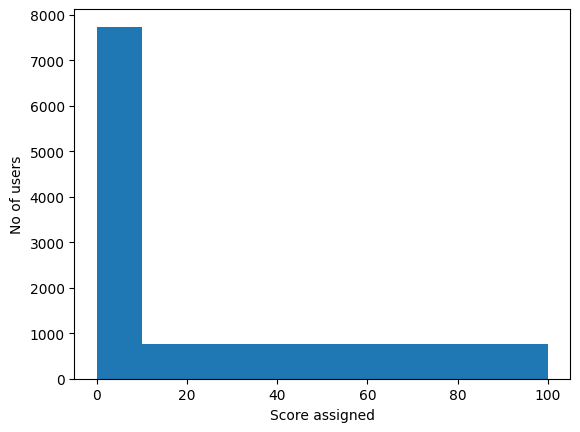

In [13]:
plt.hist(df_combined["Score1"])
plt.xlabel("Score assigned")
plt.ylabel("No of users")
plt.title("")
plt.show()

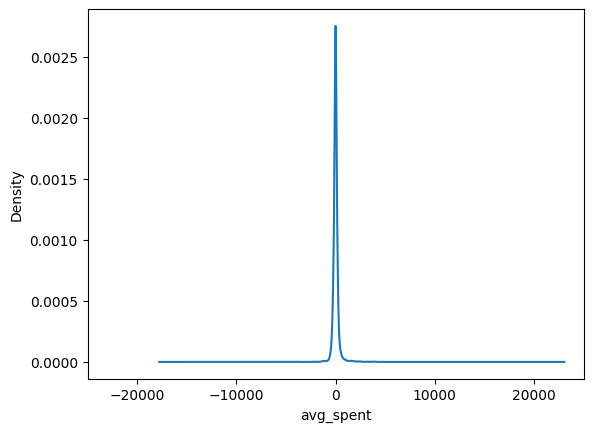

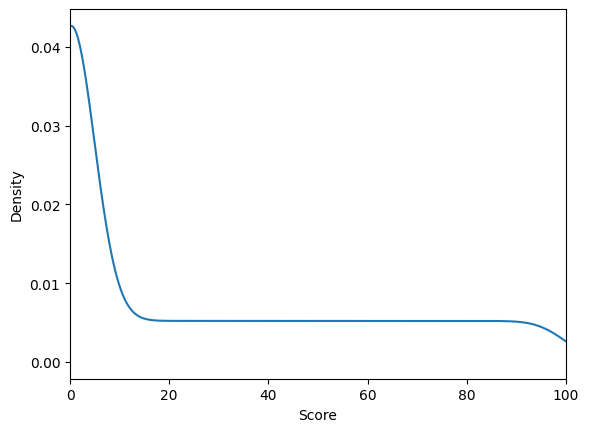

In [14]:
# import seaborn as sns
df_combined['avg_spent'].plot.kde()
plt.xlabel('avg_spent')
plt.ylabel('Density')
plt.title("")
plt.xlim(-25000,25000)
plt.show()
df_combined['Score1'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(0,100)
plt.show()

# sns.kdeplot(data=df_rule_avg_spent_pd, x='avg_spent')
# sns.set_xlim(0,2)
# plt.show()

In [15]:
df_avg = df_all.groupBy("buyer").agg(avg("net").alias("avg_spent"))
# score1 based on avg_spent
df_rule_avg_spent_pd=df_avg.toPandas()

df_rule_avg_spent_pd.loc[df_rule_avg_spent_pd['avg_spent'] <= 0, 'Score1'] = 0


hist, bins = pd.cut(df_rule_avg_spent_pd['avg_spent'], bins=100, labels=False, retbins=True, right=False)
df_rule_avg_spent_pd['Score1'] = hist + 1

print(df_rule_avg_spent_pd)

                                            buyer   avg_spent  Score1
0      \x19fc1b0697ea155a96b0824bd5a32492e01987ab -549.265120      35
1      \x0c3e947cea964408987fe43e817613ebdcc1065b   -2.202986      38
2      \x4eb42eb130995a5205db7388d5efa95da295dca1 -155.524750      37
3      \x715cda131c5a036f733ecd5d58796d0e48e21043   80.910900      38
4      \x65ed9e91a1479aa16b2a51f8bc34ff24fc346d3d -178.590195      37
...                                           ...         ...     ...
14546  \x44440aa675ae3196e2614c1a9ac897e5cd6f8545  -33.330515      37
14547  \xec0adac48bff8373da4e56ce3523d6b6fe9b1c11   21.244450      38
14548  \x45411ab2652a29601c8f23fca501a7b0b396ef56  -40.406890      37
14549  \xb7286b33f2b81d8275abb442f61dd2f9e07a747a  137.508372      38
14550  \x4c38a6962c8226ff4a7003cb66ca5c644ce0d1d2  -73.830730      37

[14551 rows x 3 columns]


# Ranking 2 - number of transactions

In [25]:
df_count = df_all.groupBy("buyer").agg(count("*").alias("number_txns"))

# score2 based on number_txns
df_rule_number_txns_pd=df_count.toPandas()

df_negative = df_rule_number_txns_pd[df_rule_number_txns_pd['number_txns'] <= 1]
df_negative['Score'] = 0

percentiles = df_rule_number_txns_pd['number_txns'].rank(pct=True)
df_rule_number_txns_pd['Score2'] = percentiles * 100

# Print result
print(df_rule_number_txns_pd)
print(df_rule_number_txns_pd['Score2'].unique())
df_rule_number_txns=spark.createDataFrame(df_rule_number_txns_pd)

                                            buyer  number_txns     Score2
0      \x19fc1b0697ea155a96b0824bd5a32492e01987ab            1  28.908666
1      \x0c3e947cea964408987fe43e817613ebdcc1065b            9  91.605388
2      \x4eb42eb130995a5205db7388d5efa95da295dca1            1  28.908666
3      \x715cda131c5a036f733ecd5d58796d0e48e21043            1  28.908666
4      \x65ed9e91a1479aa16b2a51f8bc34ff24fc346d3d           16  95.433304
...                                           ...          ...        ...
14546  \x44440aa675ae3196e2614c1a9ac897e5cd6f8545            2  64.596935
14547  \xec0adac48bff8373da4e56ce3523d6b6fe9b1c11            2  64.596935
14548  \x45411ab2652a29601c8f23fca501a7b0b396ef56            1  28.908666
14549  \xb7286b33f2b81d8275abb442f61dd2f9e07a747a            5  85.523332
14550  \x4c38a6962c8226ff4a7003cb66ca5c644ce0d1d2           79  99.219985

[14551 rows x 3 columns]
[ 28.90866607  91.60538795  95.43330355  64.59693492  80.8466772
  74.26637345  96.845

In [23]:
import pandas as pd
import numpy as np

df_count = df_all.groupBy("buyer").agg(count("*").alias("number_txns"))

# score2 based on number_txns
df_rule_number_txns_pd=df_count.toPandas()

# winsorize the transaction counts
p1, p99 = np.percentile(df_rule_number_txns_pd['number_txns'], [1, 99])
df_rule_number_txns_pd['winsorized_transactions'] = np.clip(df_rule_number_txns_pd['number_txns'], p1, p99)

# calculate the winsorized z-score of each transaction count
mean = df_rule_number_txns_pd['winsorized_transactions'].mean()
std = df_rule_number_txns_pd['winsorized_transactions'].std()
df_rule_number_txns_pd['z_value'] = (df_rule_number_txns_pd['winsorized_transactions'] - mean) / std

# assign scores based on the z-score
df_rule_number_txns_pd['zscore'] = pd.cut(df_rule_number_txns_pd['z_value'],bins=10, labels=[10, 20, 30, 40, 50, 60, 70, 80, 90,100])

print(df_rule_number_txns_pd)


                                            buyer  number_txns  \
0      \x19fc1b0697ea155a96b0824bd5a32492e01987ab            1   
1      \x0c3e947cea964408987fe43e817613ebdcc1065b            9   
2      \x4eb42eb130995a5205db7388d5efa95da295dca1            1   
3      \x715cda131c5a036f733ecd5d58796d0e48e21043            1   
4      \x65ed9e91a1479aa16b2a51f8bc34ff24fc346d3d           16   
...                                           ...          ...   
14546  \x44440aa675ae3196e2614c1a9ac897e5cd6f8545            2   
14547  \xec0adac48bff8373da4e56ce3523d6b6fe9b1c11            2   
14548  \x45411ab2652a29601c8f23fca501a7b0b396ef56            1   
14549  \xb7286b33f2b81d8275abb442f61dd2f9e07a747a            5   
14550  \x4c38a6962c8226ff4a7003cb66ca5c644ce0d1d2           79   

       winsorized_transactions   z_value zscore  
0                            1 -0.341458     10  
1                            9  0.594527     20  
2                            1 -0.341458     10  
3      

In [24]:
df_rule_number_txns_pd['zscore'].value_counts()

10     13065
20       685
30       233
40       184
100      160
50        84
60        45
70        45
90        27
80        23
Name: zscore, dtype: int64

In [20]:
# df_rule_number_txns_pd['Score3t'] = pd.qcut(df_rule_number_txns_pd['number_txns'], q=100, labels=False, duplicates='drop')

# # normalize the scores to a scale of 1 to 100
# max_score = df_rule_number_txns_pd['Score3t'].max()
# df_rule_number_txns_pd['Score3t'] = (df_rule_number_txns_pd['Score3t'] / max_score) * 100

# # set the score of the top 1% customers to 100
# top_1_percent = int(len(df_rule_number_txns_pd) * 0.01)
# top_1_percent_customers = df_rule_number_txns_pd.nlargest(top_1_percent, 'number_txns')
# df_rule_number_txns_pd.loc[top_1_percent_customers.index, 'Score3t'] = 100

# # print the dataframe with scores
# print(df_rule_number_txns_pd)

In [21]:
df_rule_number_txns_pd['number_txns'].describe()

count    14551.000000
mean         5.573912
std         51.595104
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       5005.000000
Name: number_txns, dtype: float64

In [26]:
df_rule_number_txns_pd.sort_values(by = 'number_txns', ascending = False)

,buyer,number_txns,winsorized_transactions,z_value,zscore
6648,\x3cca52f32d555d50d7e00dcdbd4303b6bc1872f2,5005,64,7.029423,100
5848,\x4c606308287a43e7861761cb3246fdec821a7568,1892,64,7.029423,100
3641,\x484585fe5b976c2afac0f2c912447059ef41bf78,1045,64,7.029423,100
10435,\xc31328e68ba9770d4c3375fd2b7c79c9904c711f,988,64,7.029423,100
4075,\x2062e18a512776ce12c1814785a90ef8d3a1d12b,921,64,7.029423,100
...,...,...,...,...,...
6080,\xd77b93701b69961f4aebca450950c3fa25b0d103,1,1,-0.341458,10
6083,\x77bb41b3a80982e19daae2cfe94403afcc613489,1,1,-0.341458,10
6085,\x6270000e0d857a1aeae418bad12b14d022225475,1,1,-0.341458,10
6086,\x4f099ff3ed7609df26d54f65531498c9748e5351,1,1,-0.341458,10


In [194]:
# df_count = df_all.groupBy("buyer").agg(count("*").alias("number_txns"))
# # score2 based on number_txns
# df_rule_number_txns_pd=df_count.toPandas()
# hist, bins=pd.cut(df_rule_number_txns_pd['number_txns'],bins=100,labels=False,retbins=True,right=False)
# df_rule_number_txns_pd['Score2']=hist
# df_rule_number_txns_pd['Score2']+=1
# print(df_rule_number_txns_pd)
# #print unique score2 values assigned
# print(df_rule_number_txns_pd['Score2'].unique())
# #converting to sparkdf
# df_rule_number_txns=spark.createDataFrame(df_rule_number_txns_pd)

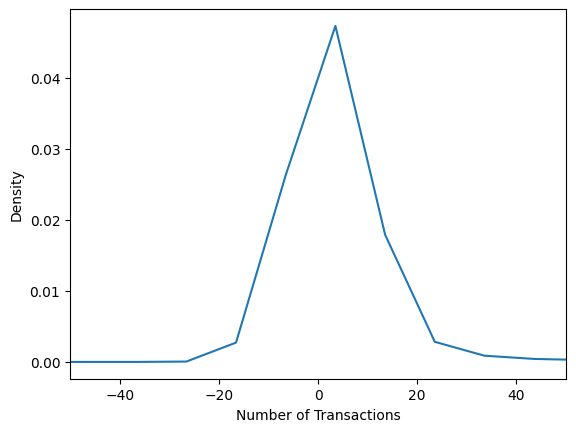

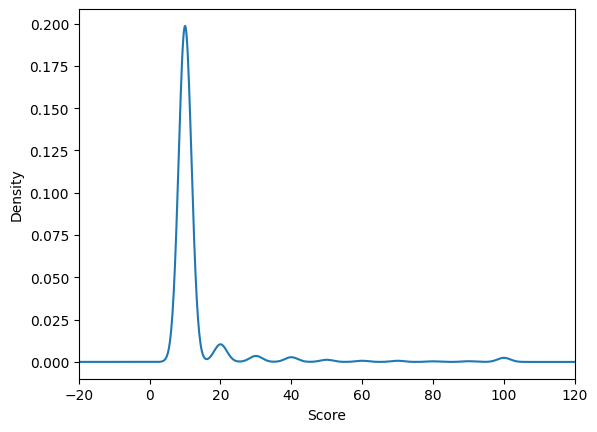

In [27]:
df_rule_number_txns_pd['number_txns'].plot.kde()
plt.xlabel('Number of Transactions')
plt.ylabel('Density')
plt.title("")
plt.xlim(-50,50)
plt.show()

df_rule_number_txns_pd['zscore'].astype(int).plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(-20,120)
plt.show()

# Diversity Ranking 3 - Number of Nft contract address held

In [34]:
df_num_nftcontract = df_all.groupBy("buyer").agg(countDistinct("nft_contract_address").alias("num_nftcontract"))
# score3 based on num_nftcontract
df_rule_num_nftcontract_pd=df_num_nftcontract.toPandas()

percentiles = df_rule_num_nftcontract_pd['num_nftcontract'].rank(pct=True)
df_rule_num_nftcontract_pd['Score3'] = percentiles * 100

print(df_rule_num_nftcontract_pd)
#print unique score3 values assigned
print(df_rule_num_nftcontract_pd['Score3'].unique())
#converting to sparkdf
df_rule_num_nftcontract=spark.createDataFrame(df_rule_num_nftcontract_pd)

                                            buyer  num_nftcontract     Score3
0      \x9e89fc379bcc7a9519468cf540a7d77e6405b422                2  95.230568
1      \x0c3e947cea964408987fe43e817613ebdcc1065b                1  45.818157
2      \x9834feb2b16328f49f59324fcd999c4e8e934dea                1  45.818157
3      \x083be8c439fe468a5529108edfcbefd21a8b6da1                1  45.818157
4      \x9b9f361dae371263d98f842bcd7091d92057269d                1  45.818157
...                                           ...              ...        ...
14546  \x3c5fb45df905eee411ecd579a2e6f60a4f860244                1  45.818157
14547  \x9371b66c542cd897c5f1a7d00b38f069e546df2e                1  45.818157
14548  \x85c35570fec7d32b3834ca5b85f1a5ce6016e0d8                1  45.818157
14549  \xd1816c9283e623663ea5a96f2435e565f627d1f1                1  45.818157
14550  \xaae13b24e44a7ded5cad777f91e67cb352cadc9a                1  45.818157

[14551 rows x 3 columns]
[95.23056835 45.81815683 99.84193526 9

In [ ]:
min_score = 10
max_score = 100


df_rule_num_nftcontract_pd['Score3'] = min_score + (df['value'] - df['value'].min()) * (max_score - min_score) / (df['value'].max() - df['value'].min())

print(df)


In [30]:
df_rule_num_nftcontract_pd['num_nftcontract'].value_counts()

1    13333
2     1047
3      134
4       27
5       10
Name: num_nftcontract, dtype: int64

In [32]:
df_rule_num_nftcontract_pd.sort_values(by = 'num_nftcontract', ascending = True)

,buyer,num_nftcontract,Score3
7275,\xc076d4cbbaf777b580693a214d4c67b01358734f,1,45.818157
9489,\x4156712fd12bf2c53ec4968004bf7810069e6fb2,1,45.818157
9490,\xaf8a6306493389b7f14596c244581b1dfa3c251c,1,45.818157
9491,\x2755f9fe42ec40d4469bebf5a8a468cbdb3cafd9,1,45.818157
9493,\x8471a680d80c6edd1c6e8d879487510f000ee466,1,45.818157
...,...,...,...
5943,\xd0a832b0ef33af4a8da6ada598409c8f8827f462,5,99.969074
2898,\x40df5c0e9bf6c2ac0ba2fbeed6035dfe92d7bfe3,5,99.969074
8012,\xff0c68cdc0dd46a6ed8ba68e887a2a673c46f4e6,5,99.969074
13486,\x1a7f055d729bb444bb0dda196d772d2ba2b28fc6,5,99.969074


In [106]:
#df_rule_num_nftcontract_pd.sort_values(by = "num_nftcontract", ascending = False)

In [101]:
# df_num_nftcontract = df_all.groupBy("buyer").agg(countDistinct("nft_contract_address").alias("num_nftcontract"))
# # score3 based on num_nftcontract
# df_rule_num_nftcontract_pd=df_num_nftcontract.toPandas()
# hist, bins=pd.cut(df_rule_num_nftcontract_pd['num_nftcontract'],bins=100,labels=False,retbins=True,right=False)
# df_rule_num_nftcontract_pd['Score3']=hist
# df_rule_num_nftcontract_pd['Score3']+=1
# print(df_rule_num_nftcontract_pd)
# #print unique score3 values assigned
# print(df_rule_num_nftcontract_pd['Score3'].unique())
# #converting to sparkdf
# df_rule_num_nftcontract=spark.createDataFrame(df_rule_num_nftcontract_pd)

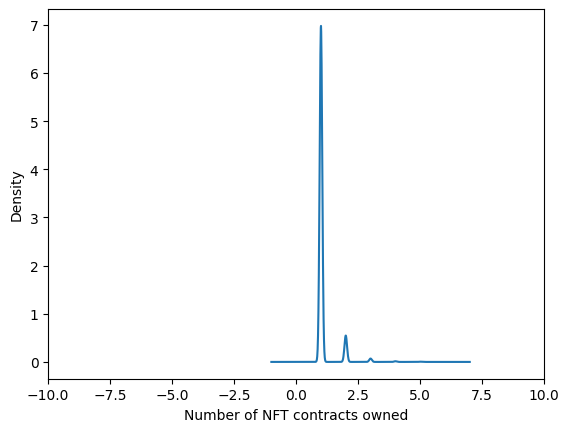

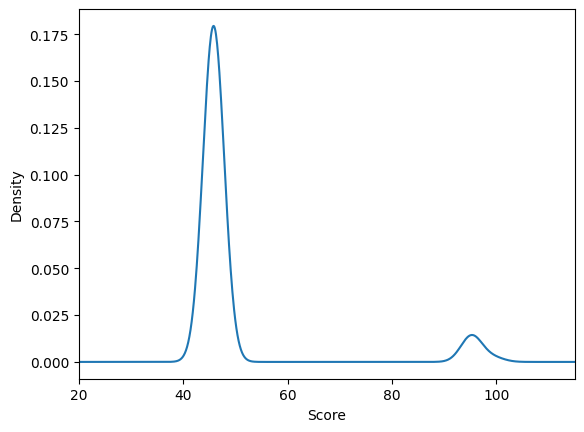

In [105]:
df_rule_num_nftcontract_pd['num_nftcontract'].plot.kde()
plt.xlabel('Number of NFT contracts owned')
plt.ylabel('Density')
plt.title("")
plt.xlim(-10,10)
plt.show()

df_rule_num_nftcontract_pd['Score3'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(20,115)
plt.show()

# Diversity Ranking 4 - Number of unique currencies transaction done in

In [109]:
unique_names = df_all.select(col("original_currency")).distinct().rdd.flatMap(lambda x: x).collect()

In [114]:
df_rule_num_currency_pd['num_currency'].value_counts()

1    14324
2      227
Name: num_currency, dtype: int64

In [118]:
df_currency = df_all.groupBy("buyer").agg(countDistinct("original_currency").alias("num_currency"))
# score4 based on num_currency
df_rule_num_currency_pd=df_currency.toPandas()

percentiles = df_rule_num_currency_pd['num_currency'].rank(pct=True)
df_rule_num_currency_pd['Score4'] = percentiles * 100

print(df_rule_num_currency_pd)
#print unique score4 values assigned
print(df_rule_num_currency_pd['Score4'].unique())
#converting back to spark df
df_rule_num_currency=spark.createDataFrame(df_rule_num_currency_pd)

                                            buyer  num_currency     Score4
0      \x611418293744761822355b086eb853f248941a26             1  49.223421
1      \x65ed9e91a1479aa16b2a51f8bc34ff24fc346d3d             1  49.223421
2      \x002118dd32f5d78da2feba2f2e56e7683f28e5c0             1  49.223421
3      \xa39ab56babaab264fec46614f745235678999f08             1  49.223421
4      \x3ff9cffda13189398e637f22e4e8e4620a034cc7             1  49.223421
...                                           ...           ...        ...
14546  \xf812eab8867076c5085f21cc7e461ce0dd076118             1  49.223421
14547  \x5b15a7e17bcf5811ebd137c16b27e49a02840d1e             1  49.223421
14548  \xa4663e48a4e2565d4d7c0ff85321294e2a313cfb             1  49.223421
14549  \xf42c2b956bcab51abb6555f5a06ee582e4581c71             1  49.223421
14550  \x4c38a6962c8226ff4a7003cb66ca5c644ce0d1d2             1  49.223421

[14551 rows x 3 columns]
[49.22342107 99.22342107]


In [119]:
# # df_currency = df_all.groupBy("buyer").agg(countDistinct("original_currency").alias("num_currency")).orderBy(desc("num_currency"))
# df_currency = df_all.groupBy("buyer").agg(countDistinct("original_currency").alias("num_currency"))
# # score4 based on num_currency
# df_rule_num_currency_pd=df_currency.toPandas()
# hist, bins=pd.cut(df_rule_num_currency_pd['num_currency'],bins=100,labels=False,retbins=True,right=False)
# df_rule_num_currency_pd['Score4']=hist
# df_rule_num_currency_pd['Score4']+=1
# print(df_rule_num_currency_pd)
# #print unique score4 values assigned
# print(df_rule_num_currency_pd['Score4'].unique())
# #converting back to spark df
# df_rule_num_currency=spark.createDataFrame(df_rule_num_currency_pd)

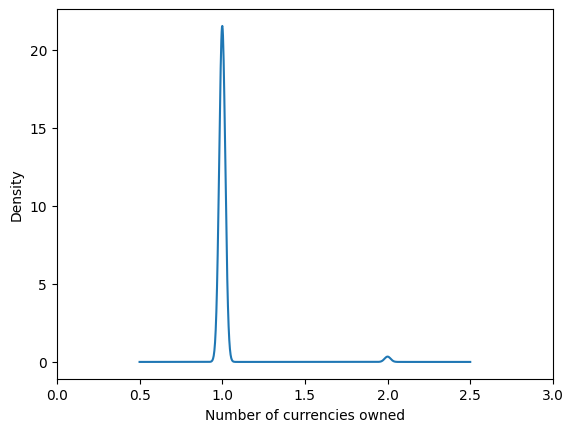

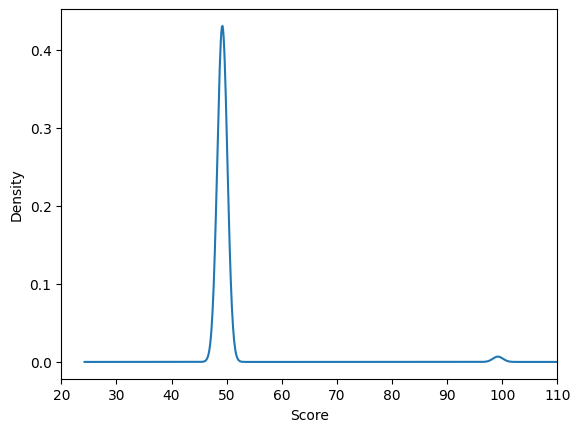

In [122]:
df_rule_num_currency_pd['num_currency'].plot.kde()
plt.xlabel('Number of currencies owned')
plt.ylabel('Density')
plt.title("")
plt.xlim(0,3)
plt.show()

df_rule_num_currency_pd['Score4'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(20,110)
plt.show()

In [22]:
# data_collect = df_all.collect()

# Diversity Ranking 5 - Average Duration (in seconds)

In [124]:
# df_all = df_all.withColumn("duration", (col("Sold_Timestamp") - col("Bought_Timestamp")))
df_all = df_all.withColumn("duration", (unix_timestamp(col("Sold_Timestamp")) - unix_timestamp(col("Bought_Timestamp"))))

In [125]:
df_all.select('duration').show(5)

+--------+
|duration|
+--------+
|  194736|
|25537934|
|   54617|
|   55842|
|    2661|
+--------+
only showing top 5 rows



In [129]:
df_avg_duration = df_all.groupBy("buyer").agg(avg("duration").alias("avg_duration"))
# score4 based on num_currency
df_rule_avg_duration_pd=df_avg_duration.toPandas()

percentiles = df_rule_avg_duration_pd['avg_duration'].rank(pct=True)
df_rule_avg_duration_pd['Score5'] = percentiles * 100

print(df_rule_avg_duration_pd)
#print unique score5 values assigned
print(df_rule_avg_duration_pd['Score5'].unique())
#converting to sparkdf
df_rule_avg_duration=spark.createDataFrame(df_rule_avg_duration_pd)

                                            buyer  avg_duration     Score5
0      \x19fc1b0697ea155a96b0824bd5a32492e01987ab  2.641374e+07  99.463954
1      \x0c3e947cea964408987fe43e817613ebdcc1065b  7.908306e+05  54.917188
2      \x4eb42eb130995a5205db7388d5efa95da295dca1  1.386550e+06  65.851144
3      \x715cda131c5a036f733ecd5d58796d0e48e21043  4.580353e+06  87.918356
4      \x65ed9e91a1479aa16b2a51f8bc34ff24fc346d3d  2.057049e+06  73.761254
...                                           ...           ...        ...
14546  \x44440aa675ae3196e2614c1a9ac897e5cd6f8545  5.147450e+06  89.471514
14547  \xec0adac48bff8373da4e56ce3523d6b6fe9b1c11  1.610996e+06  69.149887
14548  \x45411ab2652a29601c8f23fca501a7b0b396ef56  3.435712e+06  83.197031
14549  \xb7286b33f2b81d8275abb442f61dd2f9e07a747a  6.209828e+05  49.474263
14550  \x4c38a6962c8226ff4a7003cb66ca5c644ce0d1d2  3.412537e+05  38.890798

[14551 rows x 3 columns]
[99.46395437 54.91718782 65.85114425 ... 83.19703113 49.47426294
 38.89079

In [138]:
df_rule_avg_duration_pd.sort_values(by = "avg_duration", ascending = False)

,buyer,avg_duration,Score5
9984,\xf29155745c8ee222d4f7d6a2a7a50c1901f27de2,5.689628e+07,100.000000
5766,\xeb1c22baacafac7836f20f684c946228401ff01c,4.542095e+07,99.993128
10067,\xc6a7463a7ee700d035aff7bfd1ee198d680a4164,4.522751e+07,99.986255
4607,\x54b174179ae825ed630da40b625bb3c883cd40ae,4.435452e+07,99.979383
10911,\x8f04cb028b8a025bc4acf3a193db4a19d0de5bab,4.298729e+07,99.972510
...,...,...,...
13110,\xcda54f82379d6d33b2a761c0f7f5fe248dd87710,1.680000e+02,0.037798
7963,\x67e979444be34cfd3a772b29bfd923bc0740d264,1.580000e+02,0.027490
1389,\x3e2040138c9c9ce4778df397e13acb65b5474ad6,1.570000e+02,0.020617
12709,\x48180732eacbee90aeb2ee9f13c764cd12d9b5cb,1.140000e+02,0.013745


In [130]:
# df_avg_duration = df_all.groupBy("buyer").agg(avg("duration").alias("avg_duration"))
# # score4 based on num_currency
# df_rule_avg_duration_pd=df_avg_duration.toPandas()
# hist, bins=pd.cut(df_rule_avg_duration_pd['avg_duration'],bins=100,labels=False,retbins=True,right=False)
# df_rule_avg_duration_pd['Score5']=hist
# df_rule_avg_duration_pd['Score5']+=1
# print(df_rule_avg_duration_pd)
# #print unique score5 values assigned
# print(df_rule_avg_duration_pd['Score5'].unique())
# #converting to sparkdf
# df_rule_avg_duration=spark.createDataFrame(df_rule_avg_duration_pd)

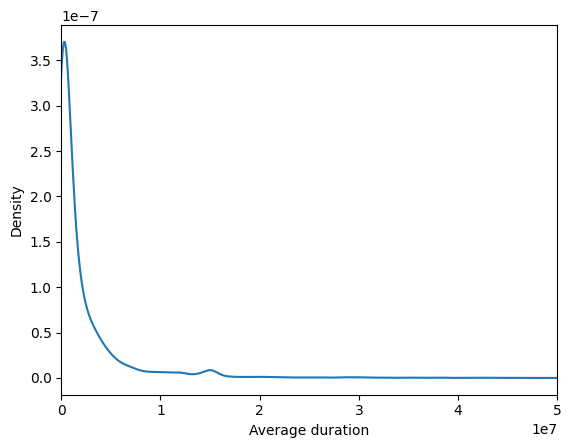

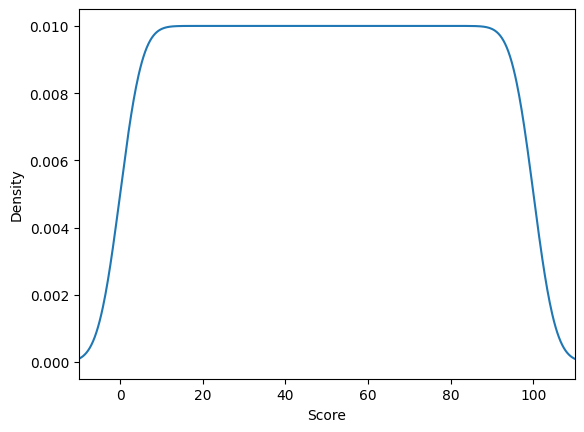

In [136]:
df_rule_avg_duration_pd['avg_duration'].plot.kde()
plt.xlabel('Average duration')
plt.ylabel('Density')
plt.title("")
plt.xlim(0e+8,0.50e+8)
plt.show()

df_rule_avg_duration_pd['Score5'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(-10,110)
plt.show()

In [26]:
type(df_avg_duration)

pyspark.sql.dataframe.DataFrame

# Ranking 6 - Frequency of each transaction

In [139]:
from pyspark.sql.functions import split
df_all = df_all.withColumn("date", split("Bought_Timestamp", " ")[0])
df_all = df_all.withColumn("time", split("Bought_Timestamp", " ")[1])

In [187]:
df_frequency = df_all.groupBy("buyer").agg(countDistinct("time").alias("frequency"))
df_rule_frequency_pd = df_frequency.toPandas()

percentiles = df_rule_frequency_pd['frequency'].rank(pct=True)
df_rule_frequency_pd['Score6'] = percentiles * 100

print(df_rule_frequency_pd)
#print unique score5 values assigned
print(df_rule_frequency_pd['Score6'].unique())
#converting to sparkdf
df_rule_frequency=spark.createDataFrame(df_rule_frequency_pd)

                                            buyer  frequency     Score6
0      \x1b9d8d8c068330d3958dee92353d0610f87e3bc7          4  89.914782
1      \x715cda131c5a036f733ecd5d58796d0e48e21043          1  30.197237
2      \x044e7277804699835766bdd8a11e35a7df67c68b          4  89.914782
3      \x1386d7a006bd547b82d72d16ba52bb764106762e          2  70.252904
4      \x58eb0cdb3527439fb8ebaa3491c4b49bb1fdc37b          4  89.914782
...                                           ...        ...        ...
14546  \xbecff511eb1f5889f07f79af7954c2271d5b4b78          1  30.197237
14547  \x5b15a7e17bcf5811ebd137c16b27e49a02840d1e          2  70.252904
14548  \x6e6669bafb001b598cbb17bd5e39077a24724b61          1  30.197237
14549  \x8bf9e70ee251a99788e020f51ee3e666d36a12f8          1  30.197237
14550  \xeb13fd2da222686623d728e72122cdfed370da82          1  30.197237

[14551 rows x 3 columns]
[ 89.91478249  30.1972373   70.25290358  96.32327675  84.07325957
  92.99360869  99.26809154  99.15469727  99.

In [182]:
#df_rule_frequency_pd['frequency'].value_counts()

In [177]:
df_rule_frequency_pd.sort_values(by = 'frequency', ascending = False)

,buyer,frequency,Score6
14110,\x8f12ba075bd3b1e560751751206d80fbefacd21f,95,100.000000
6642,\x3cca52f32d555d50d7e00dcdbd4303b6bc1872f2,76,99.993128
4055,\xb5e14dcf2520d154606254094f32c8d32d509115,66,99.986255
10146,\x8f8482a18e81dc0c20ee2c9e47d9be0cc4683029,64,99.979383
6282,\x6761bcaf2b2156c058634d9772f07374d6edef1d,59,99.972510
...,...,...,...
5992,\x11af1e21528314fb733f95039efb5504a84add8d,1,30.197237
5993,\xd98403ead18cd4351813580afcf2e231cd762309,1,30.197237
5994,\xe2868b6115019c4bd31d358a6a1ef58da6d0b027,1,30.197237
5995,\xbc8e5439fcfe654967728fc6bfbd80fba8fba8fb,1,30.197237


In [174]:
# df_frequency = df_all.groupBy("buyer").agg(countDistinct("time").alias("frequency"))
# df_rule_frequency_pd = df_frequency.toPandas()
# hist, bins=pd.cut(df_rule_frequency_pd['frequency'],bins=100,labels=False,retbins=True,right=False)
# df_rule_frequency_pd['Score6']=hist
# df_rule_frequency_pd['Score6']+=1
# print(df_rule_frequency_pd)
# #print unique score5 values assigned
# print(df_rule_frequency_pd['Score6'].unique())
# #converting to sparkdf
# df_frequency=spark.createDataFrame(df_rule_frequency_pd)

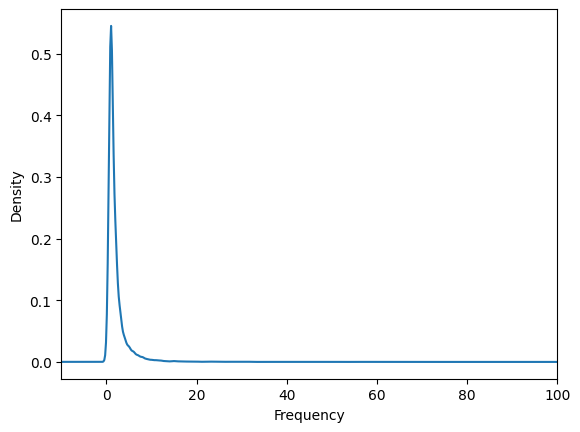

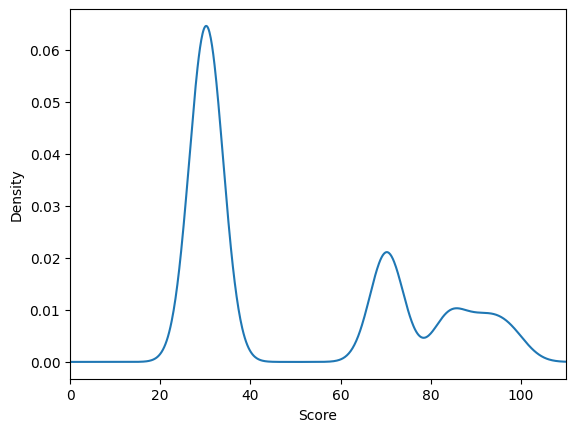

In [184]:
df_rule_frequency_pd['frequency'].plot.kde()
plt.xlabel('Frequency')
plt.ylabel('Density')
plt.title("")
plt.xlim(-10,100)
plt.show()

df_rule_frequency_pd['Score6'].plot.kde()
plt.xlabel('Score')
plt.ylabel('Density')
plt.title("")
plt.xlim(0,110)
plt.show()

# Feature Extraction for Model

In [188]:
# modeldata = reduce(lambda x,y: pd.merge(x,y, on='buyer', how='outer'), [df_avg, df_count, df_num_nftcontract, df_currency, df_avg_duration])
joined_df = df_avg.join(df_count, on='buyer', how='inner').join(df_num_nftcontract, on='buyer', how='inner').join(df_currency, on='buyer', how='inner').join(df_avg_duration, on='buyer', how='inner').join(df_frequency, on='buyer', how='inner')

In [189]:
joined_df.show(5)

+--------------------+-------------------+-----------+---------------+------------+-----------------+---------+
|               buyer|          avg_spent|number_txns|num_nftcontract|num_currency|     avg_duration|frequency|
+--------------------+-------------------+-----------+---------------+------------+-----------------+---------+
|\x19fc1b0697ea155...|         -549.26512|          1|              1|           1|      2.6413743E7|        1|
|\x0c3e947cea96440...| -2.202985666666668|          9|              1|           2|790830.5555555555|        5|
|\x4eb42eb130995a5...|-155.52474999999998|          1|              1|           1|        1386550.0|        1|
|\x715cda131c5a036...|  80.91090000000003|          1|              1|           1|        4580353.0|        1|
|\x65ed9e91a1479aa...|-178.59019499999997|         16|              1|           1|        2057049.0|        4|
+--------------------+-------------------+-----------+---------------+------------+-----------------+---

In [190]:
joined_df.count()

14551

In [193]:
joined_scores = df_rule_avg_spent.join(df_rule_number_txns, on='buyer', how='inner').join(df_rule_num_nftcontract, on='buyer', how='inner').join(df_rule_num_currency, on='buyer', how='inner').join(df_rule_avg_duration, on='buyer', how='inner').join(df_rule_frequency, on='buyer', how='inner')
joined_scores.show(5)

In [ ]:
joined_scores.write.parquet("/Users/rose/Documents/ModelScores/")
